## Using the DFT

In [1]:
import cv2
# to install cv2 use: pip install opencv-python
import math
import matplotlib.pyplot as plt 
import numpy as np


### vectorial implementation of the notch filter

from https://stackoverflow.com/questions/65483030/notch-reject-filtering-in-python

In [2]:
# shape: (W,H) are the width and height of the filter

# d0 is the radius of the filter expressed in pixels

# u_k and v_k are the center coordinates in the Fourier image plane for the notch filter
# u_k=0, v_k=0 correspond to the center of the shifted spectrum

def notch_reject_filter_vec(shape: tuple[int, int], d0: int, u_k: int, v_k: int):
    (W, H) = shape

    H_0_u = np.repeat(np.arange(W), H).reshape((W, H))
    H_0_v = np.repeat(np.arange(H), W).reshape((H, W)).transpose()

    D_uv = np.sqrt((H_0_u - W / 2 + u_k) ** 2 + (H_0_v - H / 2 + v_k) ** 2)
    D_muv = np.sqrt((H_0_u - W / 2 - u_k) ** 2 + (H_0_v - H / 2 - v_k) ** 2)

    selector_1 = D_uv <= d0
    selector_2 = D_muv <= d0

    selector = np.logical_or(selector_1, selector_2)

    H = np.ones((W, H, 2), np.uint8)
    H[selector] = 0

    return H

In [3]:
fname = 'Images/Car-Moire.png'
img = cv2.imread(fname,cv2.IMREAD_GRAYSCALE)
print('Image Shape =', img.shape)

Image Shape = (246, 168)


In [4]:
# convert the image representation to SPFP
img_float32 = np.float32(img)

In [5]:
# compute the DFT
# Note that the computed DFT has 2 channels :
# dft[:,:,0] - real values
# dft[:,:,1] - imaginary values
dft = cv2.dft(img_float32, flags = cv2.DFT_COMPLEX_OUTPUT)
# recenter the DFT , such that the center is (0,0)
dft_shift = np.fft.fftshift(dft)
# compute the frequency spectrum
# module of the complex value
magnitude_spectrum = cv2.magnitude(dft_shift[:,:,0],dft_shift[:,:,1])
# compute the logarith of magnitude such that smaller values are visible
magnitude_spectrum = 20*np.log(magnitude_spectrum)

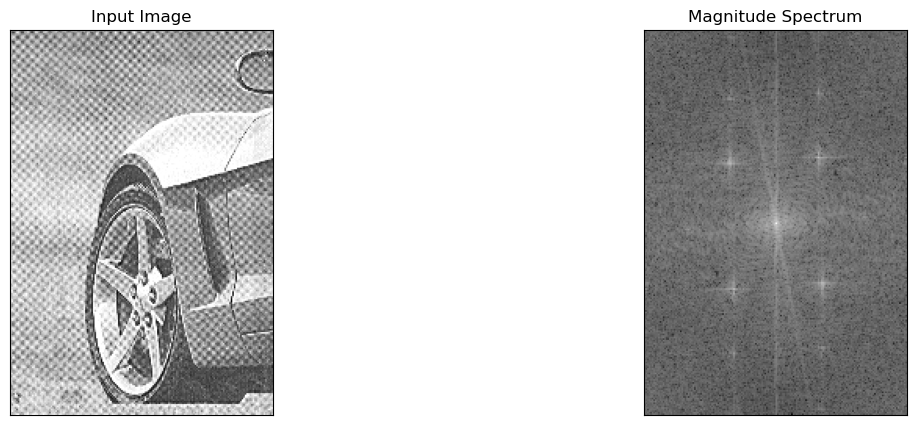

In [6]:
# display the image and the spectrum
fig = plt.figure(figsize=(15,5))
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()         

### Apply Notch filters

In [7]:
# several notch filters can be composited by multiplication

# fill in the following lists to compose multiple notch filters

d0_list = [9]
u_k_list = [38]
v_k_list = [30]

H = notch_reject_filter_vec (img.shape, d0_list[0], u_k_list[0], v_k_list[0])

for d0, u_k, v_k in zip (d0_list[1:], u_k_list[1:], v_k_list[1:]):
    Haux = notch_reject_filter_vec (img.shape, d0, u_k, v_k)

    H *= Haux
    
# apply mask and inverse DFT
dft_masked = dft_shift*H
# do not forget to undo the centering of the transform
dft_masked_ishift = np.fft.ifftshift(dft_masked)
img_back = cv2.idft(dft_masked_ishift)

# img_back should only have real values
# but let's make sure due to rounding and representation errors
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

In [8]:
# compute the DFT of the processed image (img_back)
# Note that the computed DFT has 2 channels :
# dft[:,:,0] - real values
# dft[:,:,1] - imaginary values
dft_proc = cv2.dft(img_back, flags = cv2.DFT_COMPLEX_OUTPUT)
# recenter the DFT , such that the center is (0,0)
dft_proc_shift = np.fft.fftshift(dft_proc)
# compute the frequency spectrum
# module of the complex value
filtered_spectrum = cv2.magnitude(dft_proc_shift[:,:,0],dft_proc_shift[:,:,1])
# compute the logarith of magnitude such that smaller values are visible
filtered_spectrum = 20*np.log(filtered_spectrum)

In [9]:
# compute the frequency spectrum of the MASK, 
# just for display purposes
# module of the complex value
mask_spectrum = np.sqrt(np.power(H[:,:,0],2)+np.power(H[:,:,1],2))
# compute the logarith of magnitude such that smaller values are visible
mask_spectrum = 20*np.log(mask_spectrum+0.0001)

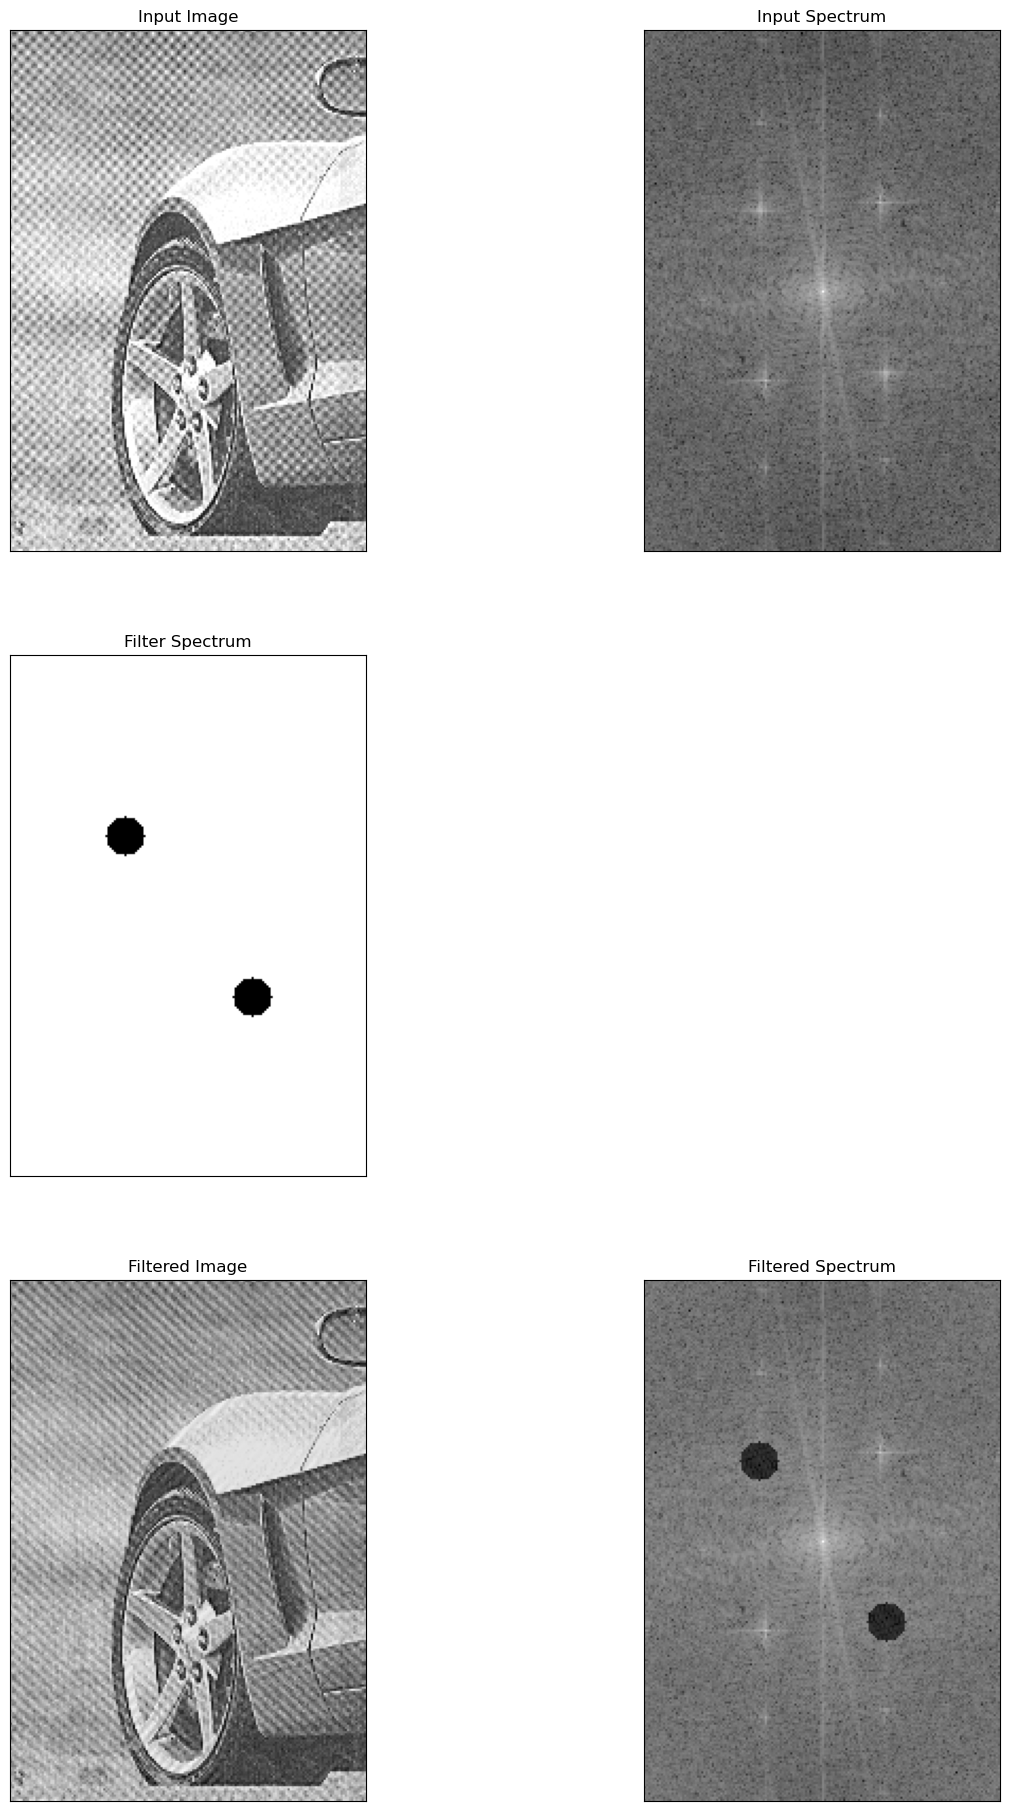

In [10]:
# display the image and the spectrum
fig = plt.figure(figsize=(15,23))
plt.subplot(321),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(322),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Input Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(323),plt.imshow(mask_spectrum, cmap = 'gray')
plt.title('Filter Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(325),plt.imshow(img_back, cmap = 'gray')
plt.title('Filtered Image'), plt.xticks([]), plt.yticks([])
plt.subplot(326),plt.imshow(filtered_spectrum, cmap = 'gray')
plt.title('Filtered Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()         

## Do it YOURSELF

* Can you do any better by multiplying multiple filters?
* Can you automatically dtetct the centers (and eventually the radius) of the filters?

In [11]:
#cv2.imwrite('Images/myImgFiltered.png',dImg)

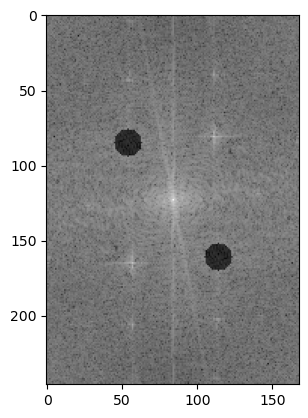

In [12]:
plt.imshow(filtered_spectrum, cmap="grey")
plt.show()

In [13]:
# several notch filters can be composited by multiplication

# fill in the following lists to compose multiple notch filters

d0_list = [9, 11]
u_k_list = [38, 40]
v_k_list = [30, -30]

H = notch_reject_filter_vec (img.shape, d0_list[0], u_k_list[0], v_k_list[0])

for d0, u_k, v_k in zip (d0_list[1:], u_k_list[1:], v_k_list[1:]):
    Haux = notch_reject_filter_vec (img.shape, d0, u_k, v_k)

    H *= Haux
    
# apply mask and inverse DFT
dft_masked = dft_shift*H
# do not forget to undo the centering of the transform
dft_masked_ishift = np.fft.ifftshift(dft_masked)
img_back = cv2.idft(dft_masked_ishift)

# img_back should only have real values
# but let's make sure due to rounding and representation errors
img_back = cv2.magnitude(img_back[:,:,0],img_back[:,:,1])

In [14]:
# compute the DFT of the processed image (img_back)
# Note that the computed DFT has 2 channels :
# dft[:,:,0] - real values
# dft[:,:,1] - imaginary values
dft_proc = cv2.dft(img_back, flags = cv2.DFT_COMPLEX_OUTPUT)
# recenter the DFT , such that the center is (0,0)
dft_proc_shift = np.fft.fftshift(dft_proc)
# compute the frequency spectrum
# module of the complex value
filtered_spectrum = cv2.magnitude(dft_proc_shift[:,:,0],dft_proc_shift[:,:,1])
# compute the logarith of magnitude such that smaller values are visible
filtered_spectrum = 20*np.log(filtered_spectrum)

In [15]:
# compute the frequency spectrum of the MASK, 
# just for display purposes
# module of the complex value
mask_spectrum = np.sqrt(np.power(H[:,:,0],2)+np.power(H[:,:,1],2))
# compute the logarith of magnitude such that smaller values are visible
mask_spectrum = 20*np.log(mask_spectrum+0.0001)

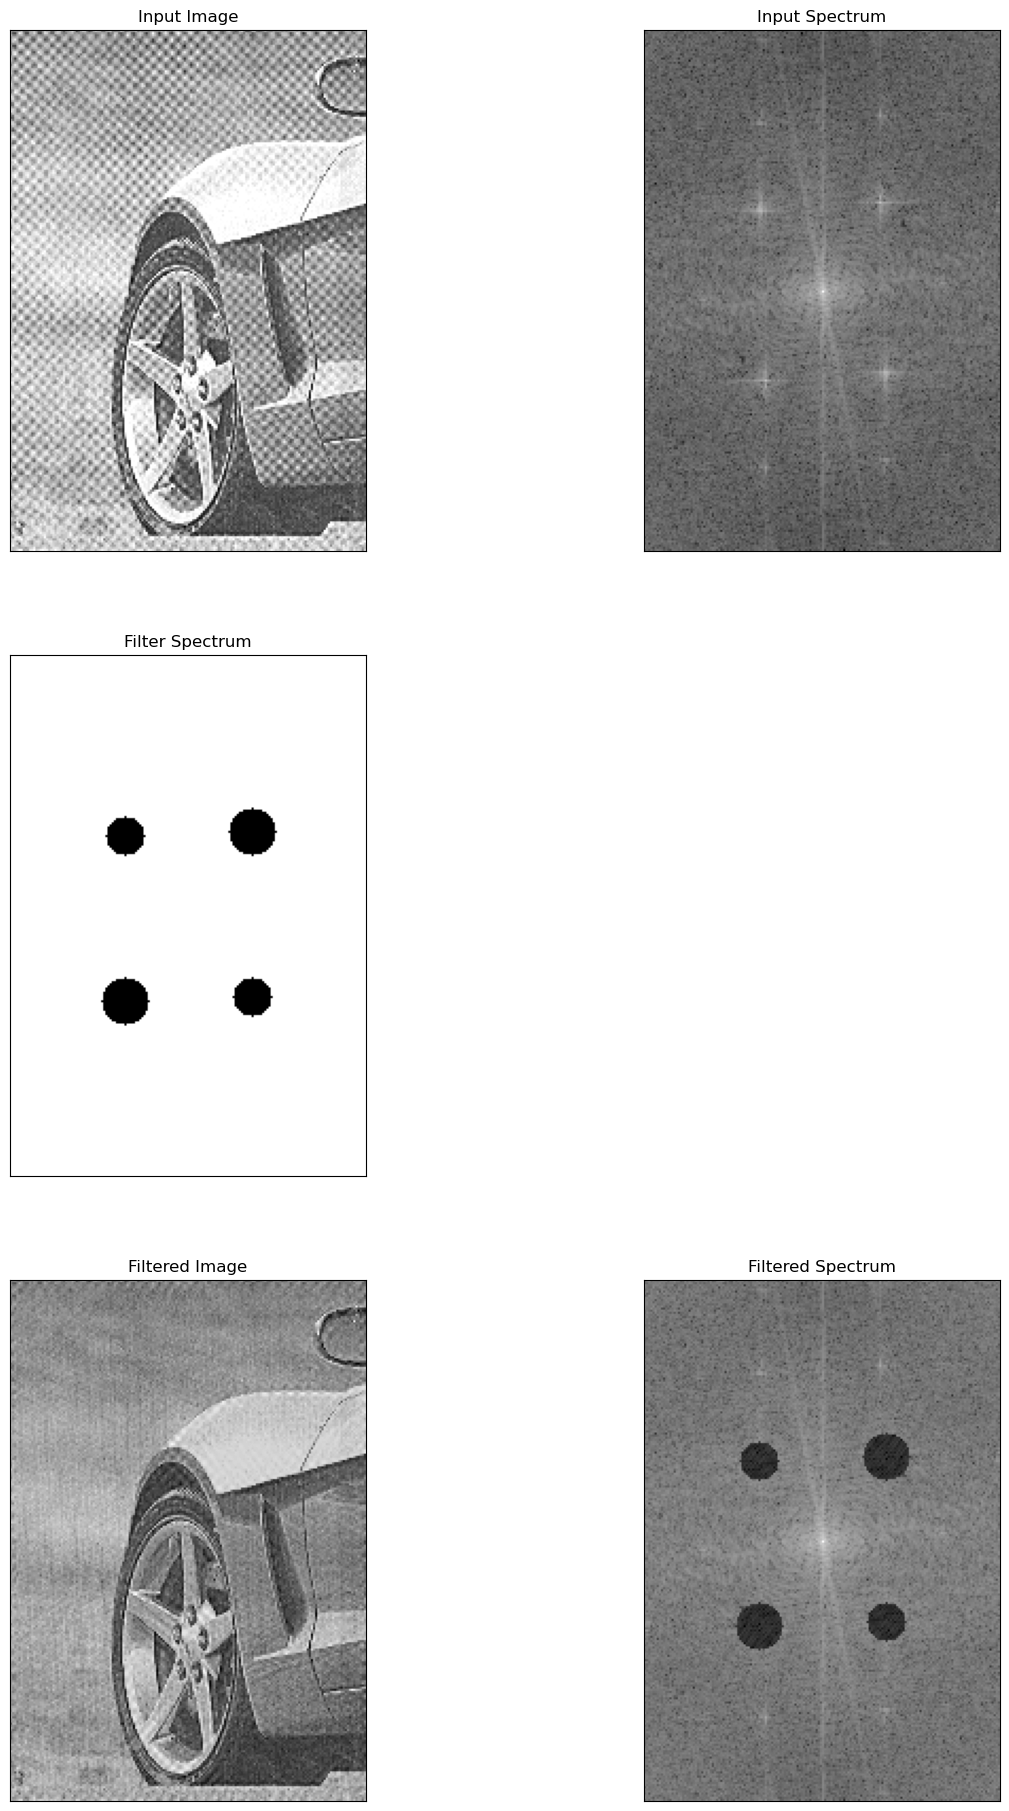

In [16]:
# display the image and the spectrum
fig = plt.figure(figsize=(15,23))
plt.subplot(321),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(322),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Input Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(323),plt.imshow(mask_spectrum, cmap = 'gray')
plt.title('Filter Spectrum'), plt.xticks([]), plt.yticks([])
plt.subplot(325),plt.imshow(img_back, cmap = 'gray')
plt.title('Filtered Image'), plt.xticks([]), plt.yticks([])
plt.subplot(326),plt.imshow(filtered_spectrum, cmap = 'gray')
plt.title('Filtered Spectrum'), plt.xticks([]), plt.yticks([])
plt.show()         

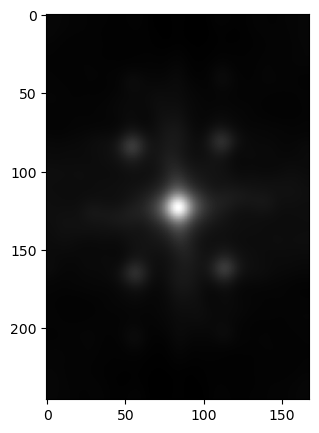

In [33]:
# magnitude_spectrum

# # OpenCV Bilateral Filter 
# m=17
# sigma_s = 75
# sigma_r = 175
# dImg = cv2.bilateralFilter(magnitude_spectrum, m, sigma_s, sigma_r)

magnitude_spectrum2 = magnitude_spectrum.copy()

W, H = magnitude_spectrum2.shape

for i in range(0, W):
    for j in range(0,H):
        magnitude_spectrum2[i][j] = ((magnitude_spectrum2[i][j]/256)**10)*256

# OpenCV Local Denoising Filter 
dImg = cv2.GaussianBlur(magnitude_spectrum2,(31,31), 0)

fig = plt.figure(figsize=(15,5))
plt.imshow(dImg, cmap='gray')

In [47]:
neighborhood_size = 5
threshold = 12.5

print(dImg.shape[-1] if dImg.ndim == 3 else 1)

# dImg2 = cv2.cvtColor(dImg, cv2.COLOR_BGR2GRAY)

ret, im2 = cv2.threshold(dImg, threshold, 255, cv2.THRESH_BINARY)
cv2.imwrite('Images/threshold.png', im2)
# dilate the thresholded peaks to eliminate "pinholes"
im3 = cv2.dilate(im2, None, iterations=2)
cv2.imwrite('Images/dilate.png', im3)

W, H = im3.shape

for i in range(0, W):
    for j in range(0, H):
        if (i - W/2)**2 + (j - H/2)**2 <= 35**2:
            im3[i][j] = 0.0

cv2.imwrite('Images/dilate2.png', im3)

im4 = cv2.dilate(im3, None, iterations=2)

cv2.imwrite('Images/dilate3.png', im4)

# contours, hier = cv2.findContours(im3, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# print('found', len(contours), 'contours')
# # draw a bounding box around each contour
# for contour in contours:
#     x,y,w,h = cv2.boundingRect(contour)
#     cv2.rectangle(magnitude_spectrum, (x,y), (x+w,y+h), (255,0,0), 2)

# cv2.imshow('Contours', magnitude_spectrum)

1


True

In [19]:
print ("That's all, folks!")

That's all, folks!
